Assignment 7: Implementing Weight learning of an MLP using the Genetic Algorithm \
Submitted by Group 5 \

Groupmembers:

1. Sajan Kumer Sarker (2111131642) (sajan.sarker@northsouth.edu)
2. Rafsan Jani Chowdhury (2011424642) (rafsan.chowdhury@northsouth.edu)
3. Rosely Mohammad (2014219642) (rosely.mohammad@northsouth.edu)

Task:\
**Implement Weight learning of an MLP using the Genetic Algorithm.** \
**Car Evaluation Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
car_evaluation = pd.read_csv('/content/drive/MyDrive/CSE445-Assignment/dataset/car.data')

In [4]:
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
car_evaluation.columns = column_names

In [5]:
print('Number of missing values: ')
print(car_evaluation.isnull().sum())

Number of missing values: 
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [6]:
X = car_evaluation.drop(columns='class')
y = car_evaluation['class']

le =LabelEncoder()
scaler = StandardScaler()

X = X.apply(lambda col: le.fit_transform(col))
y = le.fit_transform(y)

X = np.array(X, dtype=float)
y = np.array(y, dtype=int)

X = scaler.fit_transform(X)

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train Data Shape (X, y): {X_train.shape, y_train.shape}')
print(f'Validation Data Shape (X, y): {X_val.shape, y_val.shape}')
print(f'Test Data Shape (X, y): {X_test.shape, y_test.shape}')

Train Data Shape (X, y): ((1208, 6), (1208,))
Validation Data Shape (X, y): ((259, 6), (259,))
Test Data Shape (X, y): ((260, 6), (260,))


In [8]:
class MultiLayerPerceptron:
  def __init__(self, input_layer, hidden_layer, output_layer):
    self.input_layer = input_layer
    self.hidden_layer = hidden_layer
    self.output_layer = output_layer
    self.weights_hidden_input = np.random.randn(input_layer, hidden_layer) * 0.1
    self.weights_hidden_output = np.random.randn(hidden_layer, output_layer) * 0.1
    self.bias_hidden_layer = np.random.randn(hidden_layer) * 0.1
    self.bias_output_layer = np.random.randn(output_layer) * 0.1

  def forward(self, X):
    self.hidden_input = np.dot(X, self.weights_hidden_input) + self.bias_hidden_layer
    self.hidden_output = self.relu(self.hidden_input)
    self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output_layer
    self.output_output = self.softmax(self.output_input)
    return self.output_output

  def sigmoid(self, X):
    return 1/(1+np.exp(-X))

  def relu(self, X):
    return np.maximum(0, X)

  def softmax(self, X):
    return np.exp(X - np.max(X, axis=1, keepdims=True)) / np.sum(np.exp(X - np.max(X, axis=1, keepdims=True)), axis=1, keepdims=True)

  def predict(self, X):
    return np.argmax(self.forward(X), axis=1)

  def set_weights(self, weights):

    self.weights_hidden_input = weights[:self.input_layer * self.hidden_layer].reshape((self.input_layer, self.hidden_layer))
    self.weights_hidden_output = weights[self.input_layer * self.hidden_layer:self.input_layer * self.hidden_layer + self.hidden_layer * self.output_layer].reshape((self.hidden_layer, self.output_layer))

    self.bias_hidden_layer = weights[self.input_layer * self.hidden_layer + self.hidden_layer * self.output_layer:self.input_layer * self.hidden_layer + self.hidden_layer * self.output_layer + self.hidden_layer]
    self.bias_output_layer = weights[self.input_layer * self.hidden_layer + self.hidden_layer * self.output_layer + self.hidden_layer:]

  def get_weights(self):
    return np.concatenate((self.weights_hidden_input.flatten(), self.weights_hidden_output.flatten(), self.bias_hidden_layer, self.bias_output_layer))

In [9]:
def fitness_function(weights, mlp, X, y):
  mlp.set_weights(weights)
  predictions = mlp.predict(X)
  accuracy = np.mean(predictions == y)
  return accuracy

In [10]:
def crossover(parent1, parent2):
  crossover_point = random.randint(0, len(parent1))
  return np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])

In [11]:
def mutate(individual, mutation_rate):
  for i in range(len(individual)):
    if random.random() < mutation_rate:
      individual[i] += np.random.normal(scale=0.1)
  return individual

In [12]:
def genetic_algorithm(pop_size, mlp, X, y, generations, mutation_rate):
  population = [mlp.get_weights() + np.random.uniform(-1, 1, mlp.get_weights().size) for _ in range(pop_size)]
  best_fitness_per_generation = []

  for generation in range(generations):
    fitness_scores = [fitness_function(individual, mlp, X, y) for individual in population]

    best_fitness = max(fitness_scores)  # Directly get the best fitness (accuracy)
    best_fitness_per_generation.append(best_fitness)

    mating_pool = [population[i] for i in np.argsort(fitness_scores)[-pop_size//2:]]

    next_generation = []
    for _ in range(pop_size):
      parent1, parent2 = random.choice(mating_pool), random.choice(mating_pool)
      child = crossover(parent1, parent2)
      child = mutate(child, mutation_rate)
      next_generation.append(child)
    population = next_generation

  best_individual = population[np.argmax(fitness_scores)]
  return best_individual, best_fitness_per_generation

*****
# Run Genetic Algorithm

In [13]:
m, n = X_train.shape
mlp = MultiLayerPerceptron(n, 15, 4)  # initialize mlp

# run genetic algo
population = 500
generations = 1000
rate = 0.01
w, fitness = genetic_algorithm(population, mlp, X_train, y_train, generations, rate)

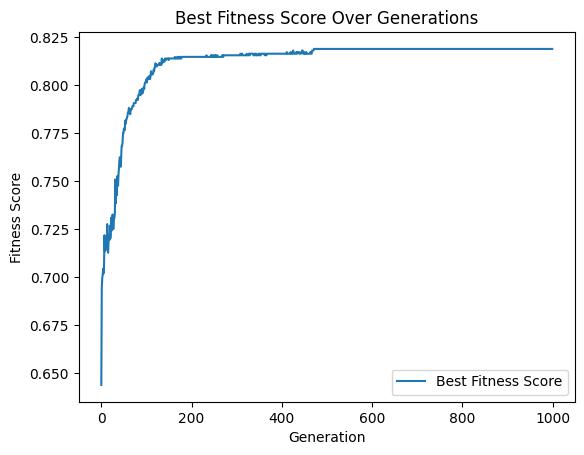

In [14]:
plt.plot(range(generations), fitness, label='Best Fitness Score')
plt.title('Best Fitness Score Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.legend()
plt.show()

Validation set accuracy: 0.8185328185328186



Text(0.5, 1.0, 'Confusion Matrix for Validation  Set')

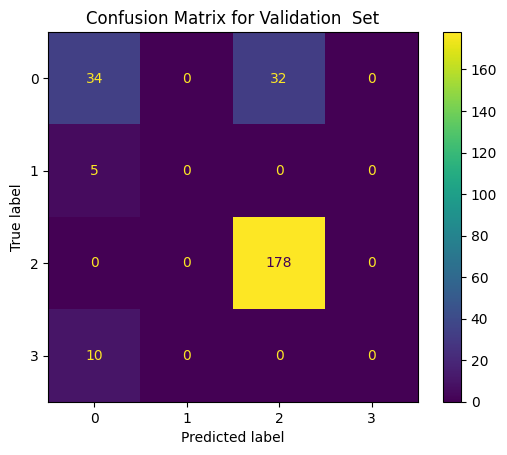

In [15]:
y_pred_val = mlp.predict(X_val)   # Predict on the val set
print(f"Validation set accuracy: {accuracy_score(y_val, y_pred_val)}")
print()
cm = confusion_matrix(y_val, y_pred_val)
cmv = ConfusionMatrixDisplay(cm)
cmv.plot()
plt.title("Confusion Matrix for Validation  Set")

Test set accuracy: 0.8153846153846154



Text(0.5, 1.0, 'Confusion Matrix for Test Set')

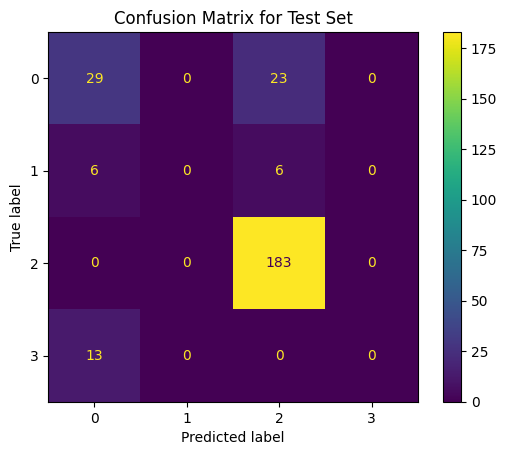

In [16]:
y_pred_test = mlp.predict(X_test)   # predicted on the test set
print(f"Test set accuracy: {accuracy_score(y_test, y_pred_test)}")
print()
cm = confusion_matrix(y_test, y_pred_test)
cmv = ConfusionMatrixDisplay(cm)
cmv.plot()
plt.title("Confusion Matrix for Test Set")